In [1]:
import numpy as np
import xarray as xr
from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe
import torch
import pickle
from torchvision.models import resnet101
from ocf_datapipes.load.nwp.nwp import OpenNWPIterDataPipe
import pandas as pd

from typing import Callable, Iterable, Optional, Union
from scipy.ndimage import zoom
import datetime as dt
from math import floor, ceil

/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/nowcasting_datamodel/models/forecast.py:196: SAWarning: This declarative base already contains a class with the same class name and module name as nowcasting_datamodel.models.forecast.ForecastValueYearMonth, and will be replaced in the string-lookup table.
  class ForecastValueYearMonth(ForecastValueSQLMixin, Base_Forecast):


Unable to import PVLive utils, please provide filenames with OpenGSP
Unable to import PVLive utils, please provide filenames with OpenGSP


In [2]:
PRETRAINED_OUTPUT_DIMS = 1_000
NWP_VARIABLE_NUM = 17
NWP_STEP_HORIZON = 37
NWP_FPATH = (
    "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
)
GSP_FPATH = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
NUM_OBS = 35_000

In [3]:
@functional_datapipe("process_nwp_pretrained")
class ProcessNWPPretrainedIterDataPipe(IterDataPipe):
    def __init__(
        self,
        base_nwp_datapipe: IterDataPipe,
        pretrained_model: Callable[[torch.Tensor], torch.Tensor],
        step : int,
        batch_size: int = 50,
        interpolate: bool = False,
        interpolation_timepoints: Optional[Iterable[Union[dt.datetime, np.datetime64]]] = None
    ) -> None:
        if interpolate:
            assert (
                interpolation_timepoints is not None
            ), "Must provide points for interpolation."
        self.source_datapipe = base_nwp_datapipe
        self.step = step
        self.pretrained_model = pretrained_model
        self.batch_size = batch_size
        self.interpolate = interpolate
        self.interpolation_timepoints = interpolation_timepoints
        
    def process_for_pretrained_input(self, nwp_batch: xr.DataArray) -> torch.Tensor:
        nwp_batch = nwp_batch.to_numpy()
        n = nwp_batch.shape[0]  # batch size for all but the last batch
        nwp_batch = nwp_batch.reshape(NWP_VARIABLE_NUM*n, 64, 68)
        nwp_batch = np.tile(nwp_batch, (3, 1, 1, 1)).reshape(NWP_VARIABLE_NUM*n, 3, 64, 68)
        nwp_batch = torch.from_numpy(np.nan_to_num(nwp_batch))
        return nwp_batch
    
    def downsample_pretrained_output(self, model_output: torch.Tensor) -> np.ndarray:
        with torch.no_grad():
            output = torch.softmax(model_output, 1)
            output = np.split(output, range(200, PRETRAINED_OUTPUT_DIMS, 200), axis=1)
            n = torch.linalg.norm(output[0], axis=1).shape[0]
            dsampled_output = torch.concat(
                [torch.linalg.norm(x, axis=1).reshape(1, n) for x in output]
            ).T
        return dsampled_output.numpy()
    
    def __iter__(self) -> Tuple[pd.DatetimeIndex, np.ndarray]:
        for nwp in self.source_datapipe:
            nwp = nwp.isel(step=self.step)  # select the horizon we want
            if self.interpolate:    
                nwp = nwp.interp(init_time_utc=self.interpolation_timepoints, method="linear")
            for batch_idx in range(1, ceil(len(nwp.init_time_utc)/self.batch_size) + 1):
                batch = nwp.isel(init_time_utc=slice(self.batch_size*(batch_idx - 1), self.batch_size*batch_idx))
                batch = batch.coarsen(
                    dim={
                        "x_osgb": floor(548/64),
                        "y_osgb": floor(704/64),
                    },
                    boundary="trim"
                ).mean()
                time_slice = batch.coords["init_time_utc"].values
                with torch.no_grad():
                    batch = self.process_for_pretrained_input(batch)
                    output = self.pretrained_model(batch)
                    output = self.downsample_pretrained_output(output)
                yield (time_slice, output)

In [4]:

gsp = xr.open_zarr(GSP_FPATH)
nwp = xr.open_zarr(NWP_FPATH)

evaluation_timeseries = (
    gsp.coords["datetime_gmt"]
    .where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0])
        & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]),
        drop=True,
    )
    .values
)
base_nwp_dpipe = OpenNWPIterDataPipe(NWP_FPATH)
model = resnet101(pretrained=True)
tscript_model = torch.jit.script(model)

BATCH_SIZE = 1_000

process_nwp_dpipe = ProcessNWPPretrainedIterDataPipe(
    base_nwp_dpipe,
    model,
    5,
    batch_size=BATCH_SIZE,
    interpolate=False,
    interpolation_timepoints=evaluation_timeseries
)
results = []
count = 0


for tstamp, data in process_nwp_dpipe:
    results.append((tstamp, data))
    count += 1
    print(f"Completed batch: {count}")
    if count >= ceil(len(nwp.init_time) / BATCH_SIZE):
        break
    
def process_results(results[])
    

/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Completed batch: 1
Completed batch: 2
Completed batch: 3
Completed batch: 4
Completed batch: 5
Completed batch: 6


In [26]:
cols = []
for var in nwp.coords["variable"].values:
    for idx in range(5):
        cols.append(f"{var}_{idx}")

In [28]:
out = pd.concat([pd.DataFrame(res[1].reshape(len(res[0]), 17*5), columns=cols, index=res[0]).reindex(pd.date_range(start=res[0][0], end=res[0][-1], freq="0.5H")).interpolate(method="linear", axis=0) for res in results]).sort_index()

In [29]:
out

,cdcb_0,cdcb_1,cdcb_2,cdcb_3,cdcb_4,lcc_0,lcc_1,lcc_2,lcc_3,lcc_4,...,prmsl_0,prmsl_1,prmsl_2,prmsl_3,prmsl_4,prate_0,prate_1,prate_2,prate_3,prate_4
2020-01-01 00:00:00,0.008336,0.128885,0.017716,0.776291,0.002863,0.000007,0.000286,0.062727,0.550593,0.010377,...,0.003815,0.000073,0.021997,0.073243,0.819043,0.034738,0.032546,0.214195,0.114623,0.068714
2020-01-01 00:30:00,0.033514,0.141029,0.015395,0.651289,0.003060,0.000007,0.000267,0.063876,0.551647,0.010502,...,0.168302,0.000896,0.018331,0.061036,0.682537,0.033329,0.031562,0.191896,0.105905,0.064127
2020-01-01 01:00:00,0.058691,0.153174,0.013074,0.526288,0.003257,0.000006,0.000248,0.065025,0.552702,0.010627,...,0.332789,0.001719,0.014666,0.048829,0.546031,0.031919,0.030577,0.169598,0.097186,0.059539
2020-01-01 01:30:00,0.083868,0.165318,0.010754,0.401286,0.003455,0.000006,0.000229,0.066174,0.553756,0.010751,...,0.497276,0.002542,0.011001,0.036622,0.409526,0.030509,0.029593,0.147299,0.088468,0.054952
2020-01-01 02:00:00,0.109046,0.177463,0.008433,0.276284,0.003652,0.000006,0.000210,0.067323,0.554810,0.010876,...,0.661763,0.003364,0.007335,0.024415,0.273020,0.029100,0.028608,0.125000,0.079750,0.050364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08 13:00:00,0.169087,0.115909,0.015656,0.041762,0.014749,0.000069,0.001228,0.078273,0.601434,0.006774,...,0.166776,0.001183,0.002725,0.074363,0.713003,0.027081,0.030660,0.073248,0.055526,0.187824
2021-11-08 13:30:00,0.154135,0.123899,0.019692,0.053929,0.013708,0.000068,0.001228,0.074659,0.610138,0.006499,...,0.234747,0.001773,0.004051,0.111544,0.586402,0.033827,0.035056,0.084854,0.060425,0.150013
2021-11-08 14:00:00,0.139182,0.131890,0.023728,0.066097,0.012667,0.000067,0.001228,0.071044,0.618843,0.006224,...,0.302718,0.002364,0.005376,0.148725,0.459801,0.040574,0.039452,0.096460,0.065323,0.112202
2021-11-08 14:30:00,0.124230,0.139880,0.027764,0.078264,0.011626,0.000065,0.001228,0.067430,0.627548,0.005949,...,0.370690,0.002955,0.006702,0.185906,0.333200,0.047320,0.043848,0.108067,0.070222,0.074390


In [ ]:
out.to_pickle()

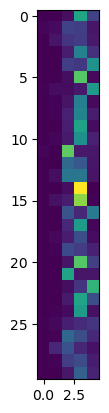

In [14]:
import matplotlib.pyplot as plt

plt.imshow(data[:, 5, :][:30])

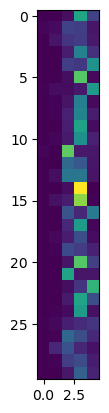

In [17]:
plt.imshow(data.reshape(1000, 17*5)[:30, 5*5:5*6])

In [ ]:
gsp = xr.open_zarr(GSP_FPATH)
nwp = xr.open_zarr(NWP_FPATH)

evaluation_timeseries = (
    gsp.coords["datetime_gmt"]
    .where(
        (gsp["datetime_gmt"] >= nwp.coords["init_time"].values[0])
        & (gsp["datetime_gmt"] <= nwp.coords["init_time"].values[-1]),
        drop=True,
    )
    .values
)
base_nwp_dpipe = OpenNWPIterDataPipe(NWP_FPATH)
model = resnet101(pretrained=True)
tscript_model = torch.jit.script(model)


process_nwp_dpipe = ProcessNWPPretrainedIterDataPipe(
    base_nwp_dpipe,
    model,
    1
)
results = []
count = 0


for tstamp, data in process_nwp_dpipe:
    results.append((tstamp, data))
    count += 1
    print(f"Completed batch: {count}")
    if count >= 50:
        break

/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tom/mambaforge/envs/xg_pv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Completed batch: 1
Completed batch: 2
Completed batch: 3
Completed batch: 4
Completed batch: 5
Completed batch: 6
Completed batch: 7
Completed batch: 8
Completed batch: 9
Completed batch: 10
Completed batch: 11
Completed batch: 12
Completed batch: 13
Completed batch: 14
Completed batch: 15
Completed batch: 16
Completed batch: 17
Completed batch: 18
Completed batch: 19
Completed batch: 20
Completed batch: 21
Completed batch: 22
Completed batch: 23
Completed batch: 24
Completed batch: 25
Completed batch: 26
Completed batch: 27
Completed batch: 28
Completed batch: 29
Completed batch: 30
Completed batch: 31
Completed batch: 32
Completed batch: 33
Completed batch: 34
Completed batch: 35
Completed batch: 36
Completed batch: 37
Completed batch: 38
Completed batch: 39
Completed batch: 40
Completed batch: 41
Completed batch: 42
Completed batch: 43
Completed batch: 44
Completed batch: 45
Completed batch: 46
Completed batch: 47
Completed batch: 48
Completed batch: 49
Completed batch: 50


In [67]:
X = np.concatenate([res[1].reshape(1, 17, 37, 5) for res in results], axis=0)

In [123]:
cols = [f"var_{x}" for x in range(17)]

In [153]:
full_cols = []
for col in cols:
    for var in range(5):
        full_cols.append(f"{col}_{var}")

In [158]:
z = pd.DataFrame(data, columns=full_cols)

In [168]:
pd.concat({idx: pd.DataFrame(x[1].reshape(37, 17*5), columns=full_cols) for idx, x in enumerate(results)})

var_0_0   var_0_1   var_0_2   var_0_3   var_0_4       var_1_0  \
0  0   0.064468  0.059041  0.097880  0.003686  0.323133  2.715238e-03   
   1   0.128047  0.010782  0.253827  0.124583  0.037282  4.187685e-03   
   2   0.028999  0.122318  0.004211  0.007486  0.364404  5.020782e-03   
   3   0.435712  0.029568  0.042454  0.036245  0.021567  3.046486e-03   
   4   0.106277  0.163391  0.021821  0.335117  0.030884  2.564394e-03   
...         ...       ...       ...       ...       ...           ...   
49 32  0.077874  0.656699  0.001902  0.003701  0.001238  6.506812e-07   
   33  0.013296  0.511196  0.011994  0.001948  0.040245  8.332619e-03   
   34  0.262141  0.286056  0.001344  0.001021  0.000198  3.035635e-03   
   35  0.002075  0.002805  0.377690  0.008451  0.340107  2.634844e-02   
   36  0.032788  0.122129  0.008541  0.057752  0.067089  1.013051e-02   

            var_1_1   var_1_2   var_1_3   var_1_4  ...      var_15_0  \
0  0   9.435118e-02  0.025247  0.807816  0.005974  ...  1.819731e-02   
   1   1.365252e-01  0.027810  0.746926  0.008137  ...  1.195044e-02   
   2   1.708302e-01  0.032336  0.691587  0.009158  ...  2.405551e-04   
   3   9.293891e-02  0.025371  0.801336  0.006118  ...  2.500035e-01   
   4   8.333526e-02  0.024014  0.823758  0.005494  ...  5.129276e-07   
...             ...       ...       ...       ...  ...           ...   
49 32  9.432794e-08  0.999657  0.000300  0.000001  ...  3.683218e-01   
   33  1.451327e-02  0.096645  0.007264  0.526121  ...  1.289920e-02   
   34  2.364514e-03  0.765354  0.014229  0.036817  ...  2.539378e-01   
   35  6.299534e-03  0.014056  0.022792  0.600650  ...  4.165262e-05   
   36  1.039155e-02  0.288595  0.012458  0.260648  ...  9.733388e-01   

       var_15_1  var_15_2      var_15_3  var_15_4  var_16_0  var_16_1  \
0  0   0.234481  0.064404  1.398795e-02  0.079069  0.018387  0.005549   
   1   0.026812  0.072205  3.257189e-02  0.453643  0.018871  0.010568   
   2   0.000045  0.002188  2.672769e-04  0.691880  0.041358  0.008931   
   3   0.012059  0.145519  7.397586e-02  0.182842  0.057272  0.008404   
   4   0.000002  0.000031  4.423059e-07  0.966422  0.065792  0.010793   
...         ...       ...           ...       ...       ...       ...   
49 32  0.467842  0.000003  8.308165e-07  0.000005  0.004698  0.025059   
   33  0.933318  0.000931  5.798584e-05  0.000174  0.004046  0.030097   
   34  0.039927  0.062580  2.128751e-02  0.071916  0.003307  0.034420   
   35  0.000306  0.000172  5.416415e-04  0.997753  0.005146  0.035029   
   36  0.002130  0.000821  5.229653e-05  0.000009  0.006633  0.012432   

       var_16_2  var_16_3  var_16_4  
0  0   0.141934  0.041183  0.329315  
   1   0.138074  0.048027  0.419122  
   2   0.178313  0.044587  0.221328  
   3   0.173784  0.041980  0.148313  
   4   0.216994  0.035393  0.139781  
...         ...       ...       ...  
49 32  0.113938  0.042833  0.062594  
   33  0.103734  0.044734  0.088495  
   34  0.101619  0.044751  0.107724  
   35  0.073457  0.043829  0.111261  
   36  0.136297  0.092856  0.077042  

[1850 rows x 85 columns]

In [157]:
# z = z.reindex(sorted(z.columns), axis=1)


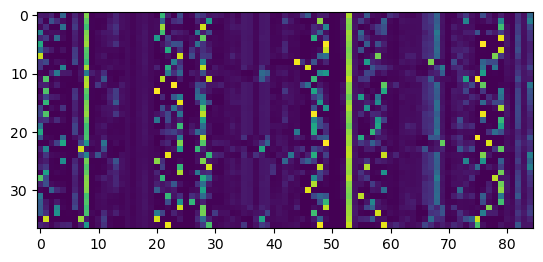

In [159]:
plt.imshow(z)

In [160]:
z.columns

Index(['var_0_0', 'var_0_1', 'var_0_2', 'var_0_3', 'var_0_4', 'var_1_0',
       'var_1_1', 'var_1_2', 'var_1_3', 'var_1_4', 'var_2_0', 'var_2_1',
       'var_2_2', 'var_2_3', 'var_2_4', 'var_3_0', 'var_3_1', 'var_3_2',
       'var_3_3', 'var_3_4', 'var_4_0', 'var_4_1', 'var_4_2', 'var_4_3',
       'var_4_4', 'var_5_0', 'var_5_1', 'var_5_2', 'var_5_3', 'var_5_4',
       'var_6_0', 'var_6_1', 'var_6_2', 'var_6_3', 'var_6_4', 'var_7_0',
       'var_7_1', 'var_7_2', 'var_7_3', 'var_7_4', 'var_8_0', 'var_8_1',
       'var_8_2', 'var_8_3', 'var_8_4', 'var_9_0', 'var_9_1', 'var_9_2',
       'var_9_3', 'var_9_4', 'var_10_0', 'var_10_1', 'var_10_2', 'var_10_3',
       'var_10_4', 'var_11_0', 'var_11_1', 'var_11_2', 'var_11_3', 'var_11_4',
       'var_12_0', 'var_12_1', 'var_12_2', 'var_12_3', 'var_12_4', 'var_13_0',
       'var_13_1', 'var_13_2', 'var_13_3', 'var_13_4', 'var_14_0', 'var_14_1',
       'var_14_2', 'var_14_3', 'var_14_4', 'var_15_0', 'var_15_1', 'var_15_2',
       'var_15_3', 'var

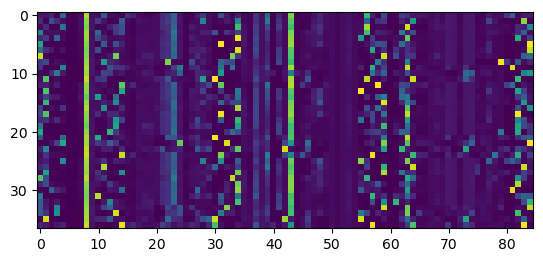

In [145]:
plt.imshow(z)

In [147]:
8 + 34

42

In [119]:
data = res[1].reshape(37, 17*5)

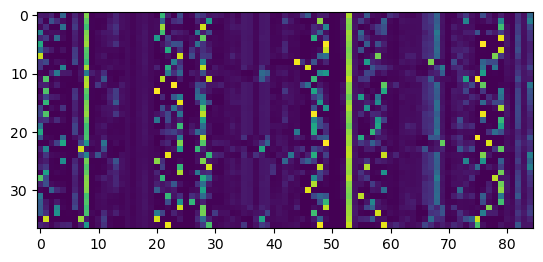

In [121]:
plt.imshow(data[:, :])

In [68]:
X

array([[[[6.44677952e-02, 5.90413027e-02, 9.78804007e-02,
          3.68621736e-03, 3.23133349e-01],
         [2.71523767e-03, 9.43511799e-02, 2.52467971e-02,
          8.07815790e-01, 5.97427227e-03],
         [1.66307464e-02, 1.84176881e-02, 3.72876823e-02,
          1.01397030e-01, 3.73881534e-02],
         ...,
         [2.89986916e-02, 1.22318238e-01, 4.21055593e-03,
          7.48618925e-03, 3.64403695e-01],
         [5.02078189e-03, 1.70830160e-01, 3.23355645e-02,
          6.91587031e-01, 9.15813260e-03],
         [7.19845854e-03, 1.55108897e-02, 8.49879682e-02,
          1.40629977e-01, 3.97597589e-02]],

        [[3.10061239e-02, 1.49990786e-02, 3.23264673e-02,
          4.74447347e-02, 2.50655059e-02],
         [3.15419212e-02, 8.56473207e-01, 8.99508130e-04,
          1.71201434e-02, 1.33949406e-02],
         [2.07682624e-05, 6.50355578e-05, 2.48370301e-02,
          9.32169795e-01, 5.92078827e-03],
         ...,
         [2.96401549e-02, 1.49068777e-02, 3.53255719e-02,
   

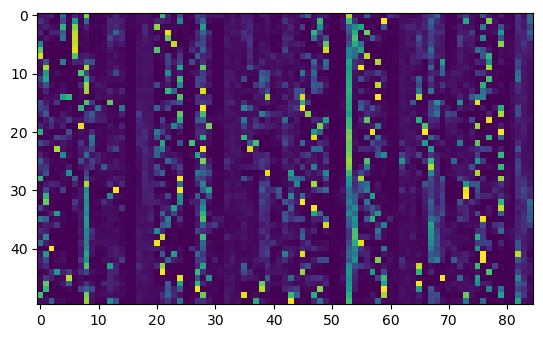

In [65]:
plt.imshow(X[:, 0, :])

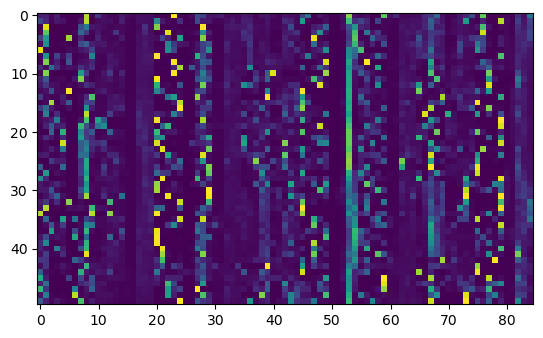

In [63]:
plt.imshow(X[:, 12, :])

In [38]:
data = res[1].reshape(37, 17, 5)

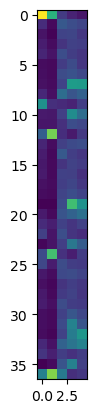

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

plt.imshow(pd.DataFrame(index=range(37), data=data[:, 12, :]))

In [19]:
data = res[1].reshape( 5)

In [20]:

data

array([[[[1.63276374e-01, 1.79356664e-01, 4.61095804e-03,
          2.21227645e-03, 6.34888420e-03],
         [2.31138966e-03, 7.96281517e-01, 1.41903097e-02,
          1.19159184e-01, 7.76682189e-03],
         [8.20787437e-03, 1.24671534e-02, 4.18896452e-02,
          9.30188969e-02, 4.81254235e-02],
         [1.49559779e-02, 1.17360512e-02, 2.88621467e-02,
          9.38788727e-02, 3.18961069e-02],
         [1.23652001e-03, 9.37554121e-01, 1.10561671e-02,
          5.03209558e-05, 2.74210181e-02]],

        [[4.85599274e-03, 1.27522023e-02, 2.39679411e-01,
          5.67851327e-02, 6.11729473e-02],
         [2.91171763e-02, 1.63241737e-02, 3.52161117e-02,
          4.09456044e-02, 2.80056987e-02],
         [9.93863121e-02, 9.45168361e-02, 2.69265734e-02,
          2.36651711e-02, 4.80862111e-02],
         [1.33839073e-02, 1.46921873e-02, 4.75513190e-02,
          3.42857353e-02, 2.86503825e-02],
         [9.69219431e-02, 2.47779295e-01, 3.37936245e-02,
          8.54011923e-02, 6.666

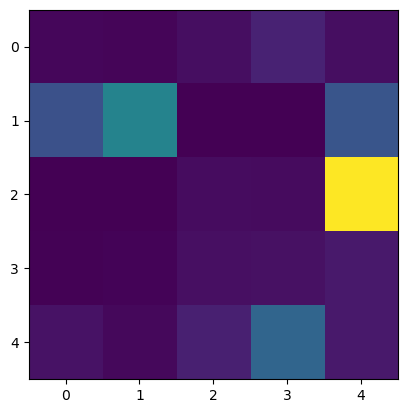

In [22]:
import matplotlib.pyplot as plt

plt.imshow(data[1, 1, :, :])

In [17]:
res[1].shape

(3145, 5)

In [13]:
data = res[1].reshape(17, 37, res[1].shape[0] / (17*37), 5)

TypeError: 'float' object cannot be interpreted as an integer

In [10]:
pd.DataFrame(index=res[0], data=res[1].reshape()

array([[0.16327637, 0.17935666, 0.00461096, 0.00221228, 0.00634888],
       [0.00231139, 0.7962815 , 0.01419031, 0.11915918, 0.00776682],
       [0.00820787, 0.01246715, 0.04188965, 0.0930189 , 0.04812542],
       ...,
       [0.04775022, 0.01838564, 0.065102  , 0.02157079, 0.03778652],
       [0.01757731, 0.35065627, 0.1417992 , 0.02805326, 0.2577816 ],
       [0.02669287, 0.00553074, 0.20431493, 0.04436798, 0.15162861]],
      dtype=float32)

In [10]:
results[0][1].shape

(157250,)